**各種ライブラリの読み込み**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix

from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
import pickle
np.random.seed(123) #Seedを指定


**データの取り込み**

参考：　https://ohke.hateblo.jp/entry/2017/07/28/230000

In [ ]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', 
    header=None)
feature = ["pregnant", "glucose", "diastolic BP", "subcutaneous fat", "serum insulin", "BMI",\
                        "diabetes pedigree function","age", "Diabetes(=1)"]
df.columns = feature
df

,pregnant,glucose,diastolic BP,subcutaneous fat,serum insulin,BMI,diabetes pedigree function,age,Diabetes(=1)
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


0 Number of times pregnant: 妊娠回数

1 Plasma glucose concentration a 2 hours in an oral glucose tolerance test: 血糖濃度(経口ブドウ糖負荷試験後2時間の値)

2 Diastolic blood pressure (mm Hg): 最低血圧(mm/Hg)

3 Triceps skin fold thickness (mm): 上腕三頭筋皮下脂肪の厚さ(mm)

4 2-Hour serum insulin (mu U/ml): 血清インスリン濃度(経口ブドウ糖負荷試験後2時間の値)

5 Body mass index (weight in kg/(height in m)2): BMI

6 Diabetes pedigree function: 糖尿病血統要因

7 Age (years): 年齢

8 Class variable (0 or 1): 糖尿病が陽性ならば1(目的変数)


**説明変数Xと目的変数yの分離**





In [ ]:
X = df.iloc[:, :8]
y = df.iloc[:, 8:].values.flatten()
print('X shape: {}, y shape: {}'.format(X.shape, y.shape))

X shape: (768, 8), y shape: (768,)


**分布の可視化**


seaboanを使用して、データをプロットします。

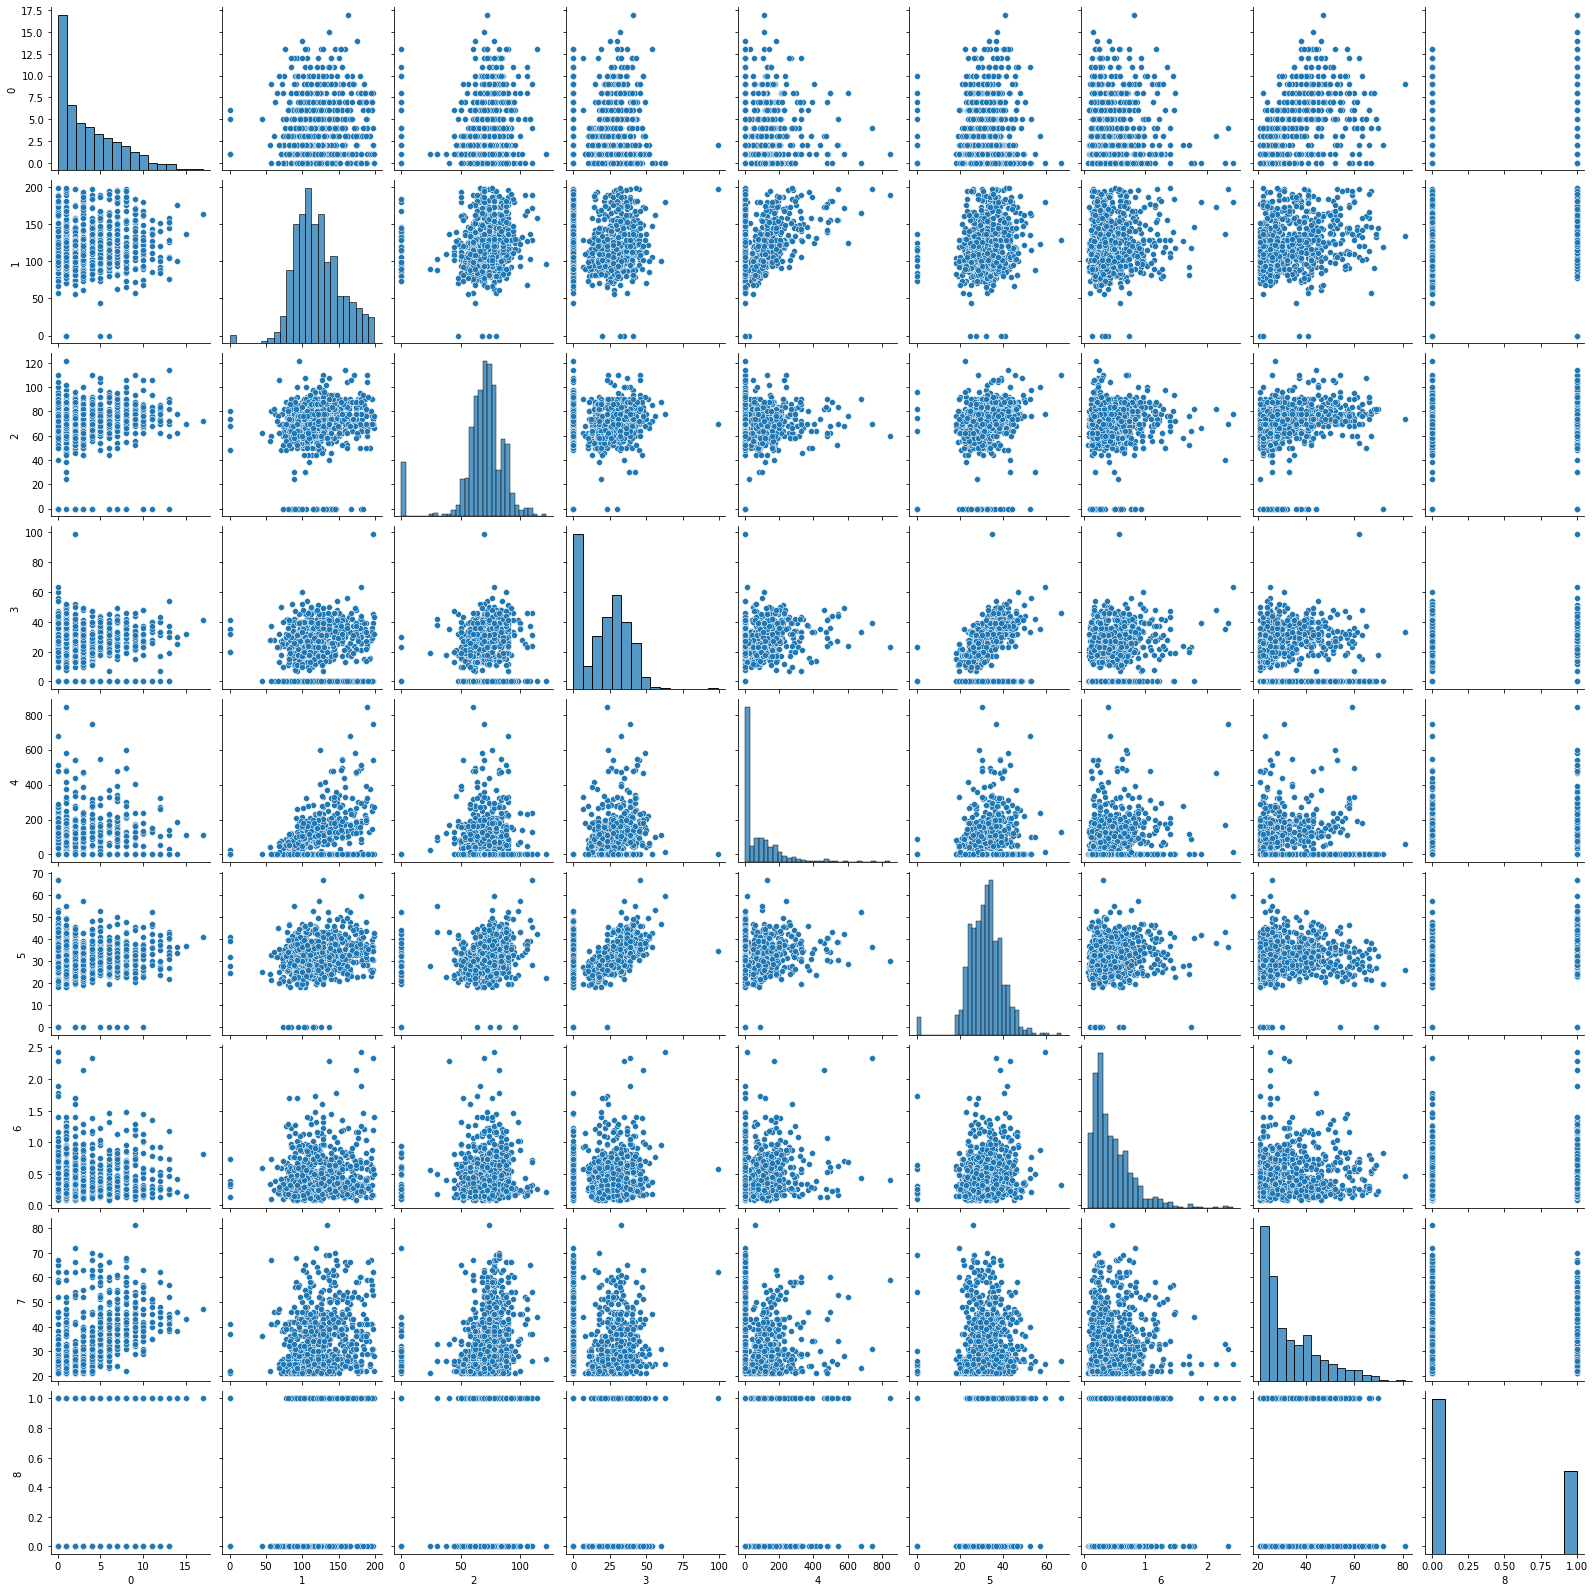

In [ ]:
sns.pairplot(df)

**欠測補完**

０になることがありえない値で０が散見されるため、欠測値を中央値で補完します。

In [ ]:
med_imp = SimpleImputer(missing_values=0, strategy='median')
med_imp.fit(X.iloc[:, 1:6])
X.iloc[:, 1:6] = med_imp.transform(X.iloc[:, 1:6])

**データの分割**

データを学習用、検証用、評価用に分割します。



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, random_state=0)

**標準化/正規化処理**

標準化とは、
説明変数の平均を０、標準偏差を１にする処理、
正規化とは、
最低値を0、最高値を1にする処理です。

機械学習のアルゴリズムの中には、説明変数毎にとる値の範囲が違いすぎると、学習が上手くいかないものがあります。
このため、どの説明変数を見ても平均が０で標準偏差が１になるようにするのが良いとされます。
（RとPythonで学ぶ実践的データサイエンス&機械学習）

In [ ]:
std_scl = StandardScaler()
std_scl.fit(X_train)
X_train = std_scl.transform(X_train)
X_test = std_scl.transform(X_test)

**SVMのチューニング**

方法①データの分離や交差検証も行うsklearn.model_selection.GridSearchCVを使用

ハイパーパラメータであるC（誤分類コスト）とgamma（境界線の複雑さ）を変化させ、検証データでの精度を評価しながら最適なモデルを探します。


In [ ]:
svc = SVC()
svc.fit(X_train, y_train)

print('Train score: {:.3f}'.format(svc.score(X_train, y_train)))
print('Test score: {:.3f}'.format(svc.score(X_test, y_test)))

svc_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

svc_grid_search = GridSearchCV(SVC(), svc_param_grid, cv=10)
svc_grid_search.fit(X_train, y_train)

print('Train score: {:.3f}'.format(svc_grid_search.score(X_train, y_train)))
print('Test score: {:.3f}'.format(svc_grid_search.score(X_test, y_test)))


print('Best parameters: {}'.format(svc_grid_search.best_params_))
print('Best estimator: {}'.format(svc_grid_search.best_estimator_))


Train score: 0.826
Test score: 0.771
Train score: 0.755
Test score: 0.792
Best parameters: {'C': 10, 'gamma': 0.001}
Best estimator: SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


方法②
forループでパラメータを1つずつ変えて最高スコアとなるパラメータを見つけ出す

In [ ]:
print ("-Tuning------------------")
best_val_acc_rf = 0.
best_val_acc_svm = 0.

# rbf SVC
print("SVC rbf") # SVMのチューニング
for c in [0.001, 0.01, 0.1, 1, 10, 100]: # ハイパーパラメータ
    for g in [0.001, 0.01, 0.1, 1, 10, 100 ]: # ハイパーパラメータ
        # ハイパーパラメータの組み合わせ毎にモデルを用意    
        clf = SVC(kernel = 'rbf', C = c, gamma = g, probability = True, random_state = 0)
        clf.fit(X_train, y_train) # フィッティング
        pred_y_train = clf.predict(X_train)               # 学習データで予測
        train_acc = accuracy_score(y_train, pred_y_train) # 学習データの正解率
        pred_val_y = clf.predict(X_vaｌ)             # 検証データで予測
        val_acc = accuracy_score(y_val, pred_val_y) # 検証データの正解率
        print( "c:%s\tgamma:%s\ttrain_acc:%.3f\tval_acc:%.3f" \
              %(c, g, train_acc, val_acc) )
        if best_val_acc_svm < val_acc: # 暫定ベストのモデルか確認
            best_val_param_svm = [c, g] # パラメータ格納
            best_clf_svm       = clf # モデルコピー
            best_val_acc_svm   = val_acc # ベストな正解率を更新

-Tuning------------------
SVC rbf
c:0.001	gamma:0.001	train_acc:0.650	val_acc:0.618
c:0.001	gamma:0.01	train_acc:0.650	val_acc:0.618
c:0.001	gamma:0.1	train_acc:0.650	val_acc:0.618
c:0.001	gamma:1	train_acc:0.650	val_acc:0.618
c:0.001	gamma:10	train_acc:0.650	val_acc:0.618
c:0.001	gamma:100	train_acc:0.650	val_acc:0.618
c:0.01	gamma:0.001	train_acc:0.650	val_acc:0.618
c:0.01	gamma:0.01	train_acc:0.650	val_acc:0.618
c:0.01	gamma:0.1	train_acc:0.650	val_acc:0.618
c:0.01	gamma:1	train_acc:0.650	val_acc:0.618
c:0.01	gamma:10	train_acc:0.650	val_acc:0.618
c:0.01	gamma:100	train_acc:0.650	val_acc:0.618
c:0.1	gamma:0.001	train_acc:0.650	val_acc:0.618
c:0.1	gamma:0.01	train_acc:0.650	val_acc:0.618
c:0.1	gamma:0.1	train_acc:0.722	val_acc:0.618
c:0.1	gamma:1	train_acc:0.650	val_acc:0.618
c:0.1	gamma:10	train_acc:0.650	val_acc:0.618
c:0.1	gamma:100	train_acc:0.650	val_acc:0.618
c:1	gamma:0.001	train_acc:0.650	val_acc:0.618
c:1	gamma:0.01	train_acc:0.755	val_acc:0.618
c:1	gamma:0.1	train_acc:0.824

**ランダムフォレストのチューニング**

ハイパーパラメータである作成するツリーの数と、作成するツリーの階層を変化させ、検証データでの精度を評価しながら最適なモデルを探します。

In [ ]:
print("RF") # ランダムフォレストのチューニング
for n in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]: # ハイパーパラメータ
    for d in [1, 2, 5, 10, 20 ,50]: # ハイパーパラメータ
        # ハイパーパラメータの組み合わせ毎にモデルを用意
        clf = RandomForestClassifier(n_estimators = n,max_depth = d,random_state = 0)
        clf.fit(X_train, y_train) # フィッティング
        pred_train_y = clf.predict(X_train) # 学習データで予測
        train_acc = accuracy_score(y_train, pred_train_y) # 学習データの正解
        pred_val_y = clf.predict(X_val) # 検証データで予測
        val_acc = accuracy_score(y_val, pred_val_y) # 検証データの正解
        print("n_est:%s\tmax_depth:%s\ttrain_acc:%.3f\tval_acc:%.3f" \
              %(n, d, train_acc, val_acc))
        if best_val_acc_rf < val_acc: # 暫定ベストのモデルか確認
            best_val_param_rf = [n, d] # パラメータ格納
            best_clf_rf       = clf # モデルコピー
            best_val_acc_rf   = val_acc # ベストな正解率を更新

RF
n_est:1	max_depth:1	train_acc:0.650	val_acc:0.618
n_est:1	max_depth:2	train_acc:0.674	val_acc:0.382
n_est:1	max_depth:5	train_acc:0.789	val_acc:0.368
n_est:1	max_depth:10	train_acc:0.815	val_acc:0.382
n_est:1	max_depth:20	train_acc:0.877	val_acc:0.618
n_est:1	max_depth:50	train_acc:0.877	val_acc:0.618
n_est:2	max_depth:1	train_acc:0.650	val_acc:0.618
n_est:2	max_depth:2	train_acc:0.681	val_acc:0.382
n_est:2	max_depth:5	train_acc:0.803	val_acc:0.368
n_est:2	max_depth:10	train_acc:0.882	val_acc:0.417
n_est:2	max_depth:20	train_acc:0.868	val_acc:0.618
n_est:2	max_depth:50	train_acc:0.868	val_acc:0.618
n_est:5	max_depth:1	train_acc:0.650	val_acc:0.618
n_est:5	max_depth:2	train_acc:0.722	val_acc:0.382
n_est:5	max_depth:5	train_acc:0.833	val_acc:0.382
n_est:5	max_depth:10	train_acc:0.944	val_acc:0.368
n_est:5	max_depth:20	train_acc:0.947	val_acc:0.375
n_est:5	max_depth:50	train_acc:0.947	val_acc:0.375
n_est:10	max_depth:1	train_acc:0.674	val_acc:0.417
n_est:10	max_depth:2	train_acc:0.725	

**アルゴリズム間の正解率比較**

SVMとランダムフォレストのベストモデルで精度を比較します。


In [ ]:
if best_val_acc_rf < best_val_acc_svm: # SVMがランダムフォレストより良い場合
    best_algo      = 'SVM'
    best_val_param = best_val_param_svm # ベストなSVMハイパーパラメータ取得
    best_clf       = best_clf_svm       # ベストなSVMモデル取得
    best_val_acc   = best_val_acc_svm   # ベストなSVM正解率取得
else:    
    best_algo      = 'RF'    
    best_val_param = best_val_param_rf # ベストなランダムフォレストハイパーパラメータ取得
    best_clf       = best_clf_rf       # ベストなランダムフォレストモデル取得
    best_val_acc   = best_val_acc_rf   # ベストなランダムフォレスト正解率取得
    
print ("-Best Model------------------")
print(best_algo) # 最適パラメータの確認
print("val_acc.:%.4f" % best_val_acc)
print(best_val_param) # 最適パラメータの確認

print ("-Best RF------------------")
print("val_acc.:%.4f" % best_val_acc_rf)
print(best_val_param_rf) # 最適パラメータの確認
print ("-Best SVM------------------")
print("val_acc.:%.4f" % best_val_acc_svm)
print(best_val_param_svm) # 最適パラメータの確認

-Best Model------------------
SVM
val_acc.:0.6181
[0.001, 0.001]
-Best RF------------------
val_acc.:0.0000
[1, 1]
-Best SVM------------------
val_acc.:0.6181
[0.001, 0.001]


**ランダムフォレストの重要度確認**


ランダムフォレストはそれぞれの説明変数がどの程度結果に影響を与えたか確認できます。
モデルのfeature_importances_という属性を呼び出すことで、重要度を確認します。
重要度が高い説明変数に違和感を感じた場合には、使用する説明変数の見直しを検討することで結果が改善することがあります。
このような確認できるのがランダムフォレストのメリットです。

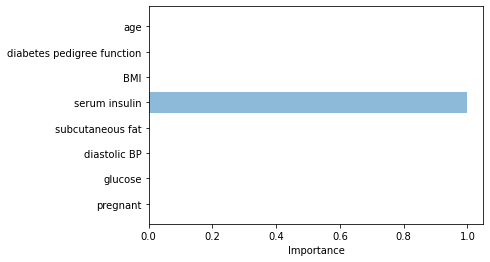

In [ ]:
features = ["pregnant", "glucose", "diastolic BP", "subcutaneous fat", "serum insulin", "BMI", "diabetes pedigree function","age"]
import matplotlib.pyplot  as plt
plt.barh(range(len(features)), best_clf_rf.feature_importances_, align='center', alpha = 0.5)
plt.yticks( range( len(features) ), features )
plt.xlabel('Importance')
plt.show()

**再現率と適合率のトレードオフ確認と閾値設定**



ここまではモデルにクラスを予測させていましたが、ここではクラスごとの確率を予測させます。
predict()に代わって、predict_proba()を使って確率を予測します。
予測確率が閾値を超えたときに、そのクラスに該当するものと予測します。
閾値を1%刻みで変更しながら正解率、再現率、適合率の変化を確認します。

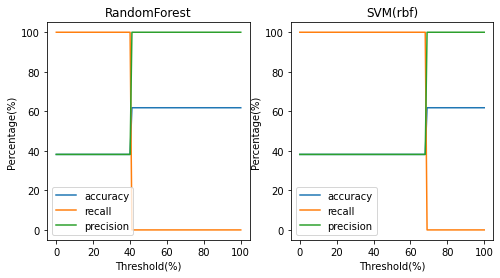

In [ ]:
# 再現率と適合率のトレードオフ確認用の関数を作成
def change_threshold(y_val, pred_proba_val_y):
    # val_yは、検証データの教師ラベル
    # pred_proba_val_yは、検証データの予測確率
    val_acc_list = []
    val_prec_list = []
    val_rec_list = []
    for thres_p in range(101): # 0%から100%まで1%刻みで閾値変更
        # 予測確率pが閾値以上ならば1、そうでないならば0
        pred_val_y = [1. if p >= thres_p / 100. else 0. for p in pred_proba_val_y]
        temp_cm = confusion_matrix(y_val, pred_val_y) # 混合行列作成
        val_acc = (temp_cm[0][0] + temp_cm[1][1]) / np.sum(temp_cm) * 100.
        val_acc_list.append(val_acc) # 正解率をリストに追加
        val_prec = (temp_cm[1][1] + 1.e-18) / (temp_cm[0][1] + temp_cm[1][1] + 1.e-18) * 100.
        val_prec_list.append(val_prec) # 適合率をリストに追加
        val_rec = (temp_cm[1][1]) / np.sum(temp_cm[1]) * 100.
        val_rec_list.append(val_rec) # 再現率をリストに追加
    return val_acc_list, val_prec_list, val_rec_list

pred_proba_val_y = best_clf_rf.predict_proba(X_val)[:, 1] # 確率を予測
val_acc_rf, val_prec_rf, val_rec_rf = change_threshold(y_val, pred_proba_val_y)

pred_proba_val_y = best_clf_svm.predict_proba(X_val)[:, 1] # 確率を予測
val_acc_svm, val_prec_svm, val_rec_svm = change_threshold(y_val, pred_proba_val_y)

plt.figure(figsize = (8, 4)) # 図の大きさ指定
plt.subplot(1, 2, 1) # 1行2列の図を作成。以降、まずは1つ目の図を指定
plt.title("RandomForest") # タイトル追加
plt.plot(val_acc_rf, label = 'accuracy')   # ランダムフォレストの正解率
plt.plot(val_rec_rf, label = 'recall')     # ランダムフォレストの再現率
plt.plot(val_prec_rf, label = 'precision') # ランダムフォレストの適合率  
plt.xlabel('Threshold(%)')   # x軸名
plt.ylabel('Percentage(%)')  # y軸名
plt.legend() # 凡例追加
plt.subplot(1, 2, 2) # ２つ目の図を指定
plt.title("SVM(rbf)") # タイトル追加
plt.plot(val_acc_svm, label = 'accuracy')   # SVMの正解率
plt.plot(val_rec_svm, label = 'recall')     # SVMの再現率
plt.plot(val_prec_svm, label = 'precision') # SVMの適合率 
plt.xlabel('Threshold(%)')  # x軸名
plt.ylabel('Percentage(%)') # y軸名
plt.legend() # 凡例追加
plt.show() # 図の描画

In [ ]:
print ("-Testing------------------")
pred_proba_test_y = best_clf_svm.predict_proba(X_test)[:,1] # ベストなSVMで確率を予測
# 閾値12%の時に際銀率99%を期待できることをval_rec_svm変数で確認。
# 閾値12%以上でラベルを１、12%未満で0と予測
pred_val_y = [1. if p >= 12. / 100. else 0. for p in pred_proba_test_y]
# 閾値12%の際の混合行列を計算、出力
temp_cm = confusion_matrix(y_test, pred_val_y)
print(temp_cm)

-Testing------------------
[[  0 130]
 [  0  62]]


In [ ]:
# モデルを保存する
filename = 'ml_svm_model.sav'
pickle.dump( best_clf_svm, open(filename, 'wb') )
filename = 'ml_rf_model.sav'
pickle.dump( best_clf_rf, open(filename, 'wb') )